In [1]:
from pandas import Series
import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression


from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve, f1_score, plot_confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score

import warnings
warnings.filterwarnings("ignore")

from datetime import datetime

In [2]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [3]:
# Визуализация числовых признаков

def num_plots(data, feat, tint):
    fig = plt.figure()
    axes_h = fig.add_axes([0, 0, 0.7, 0.4])
    axes_h.hist(data[feat], 50, color=tint)
    axes_h.set_title(feat)
    axes_b = fig.add_axes([1, 0, 0.7, 0.4])
    axes_b.boxplot(data[feat], vert=False)


# Границы выбросов

def out_lower(feat):
    return 2.5*scoring[feat].quantile(0.25) - 1.5*scoring[feat].quantile(0.75)

def out_upper(feat):
    return 2.5*scoring[feat].quantile(0.75) - 1.5*scoring[feat].quantile(0.25)


# Распределение категориальных признаков

def cat_plots(data, feat, tint, k):
    axes_k = fig.add_axes([k%3, k//3, 0.6, 0.7])
    axes_k.hist(data[feat], color=tint)
    axes_k.set_title(feat, fontsize = 22)

In [4]:
# Набор метрик
def metrics(y_valid, y_pred, y_pred_probs):
    m = pd.DataFrame(index = ['accuracy', 'precision', 'recall', 'f1_score', 'ROC_AUC'])
    m['scores'] = [accuracy_score(y_valid,y_pred), precision_score(y_valid,y_pred), 
                   recall_score(y_valid,y_pred), f1_score(y_valid,y_pred), 
                   roc_auc_score(y_valid, y_pred_probs)]
    return(m)


# Кривая ROC AUC
def roc_auc_curve(y_valid, y_pred_probs):
    fpr, tpr, threshold = roc_curve(y_valid, y_pred_probs)
    roc_auc = roc_auc_score(y_valid, y_pred_probs)

    plt.figure()
    plt.plot([0, 1], label='Baseline', linestyle='--')
    plt.plot(fpr, tpr, label = 'Regression')
    plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc = 'lower right')
    plt.show()

In [5]:
RANDOM_SEED = 42
!pip freeze > requirements.txt

In [ ]:
# Импорт данных в KAGGLE

#scoring_train = pd.read_csv('/kaggle/input/sf-dst-scoring/train.csv')
#scoring_test = pd.read_csv('/kaggle/input/sf-dst-scoring/test.csv')
#sample_submission = pd.read_csv('/kaggle/input/sf-dst-scoring/sample_submission.csv')

In [6]:
# Импорт данных в JUPITER

scoring_train = pd.read_csv('project_05_scoring/train.csv')
scoring_test = pd.read_csv('project_05_scoring/test.csv')
sample_submission = pd.read_csv('project_05_scoring/sample_submission.csv')

In [7]:
# Просмотр данных

display('scoring_train: ', scoring_train.shape, scoring_train.head(3))
display('scoring_test: ', scoring_test.shape, scoring_test.head(3))

'scoring_train: '

(73799, 19)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0
2,25887,01FEB2014,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0


'scoring_test: '

(36349, 18)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport
0,74835,22MAR2014,GRD,M,29,Y,Y,0,0,-2.271884,3,50,1,2,50000,1,4,N
1,17527,24JAN2014,SCH,F,39,N,N,5,0,-1.504999,2,50,1,2,5000,4,3,N
2,75683,23MAR2014,UGR,M,50,Y,Y,0,0,-1.691339,1,50,1,2,30000,1,3,Y


In [8]:
# Объединение тренировочной и тестовой части в один датасет для обработки признаков 

scoring_train['part'] = 0  # пометка тренировочных данных
scoring_test['part'] = 1  # пометка тестовых данных

scoring = scoring_train.append(scoring_test, sort=False).reset_index(drop=True)

In [9]:
display(scoring.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   app_date          110148 non-null  object 
 2   education         109670 non-null  object 
 3   sex               110148 non-null  object 
 4   age               110148 non-null  int64  
 5   car               110148 non-null  object 
 6   car_type          110148 non-null  object 
 7   decline_app_cnt   110148 non-null  int64  
 8   good_work         110148 non-null  int64  
 9   score_bki         110148 non-null  float64
 10  bki_request_cnt   110148 non-null  int64  
 11  region_rating     110148 non-null  int64  
 12  home_address      110148 non-null  int64  
 13  work_address      110148 non-null  int64  
 14  income            110148 non-null  int64  
 15  sna               110148 non-null  int64  
 16  first_time        11

None

In [10]:
# Столбец с пропусками ('уровень образования')

display(scoring['education'].value_counts())
print('пропусков', scoring['education'].isnull().sum())

SCH    57998
GRD    34768
UGR    14748
PGR     1865
ACD      291
Name: education, dtype: int64

пропусков 478


In [11]:
# Заполнение пропусков

scoring['education'] = scoring['education'].fillna('SCH')

In [12]:
# Преобразование данных в столбце 'дата подачи заявки'

scoring['app_date'] = pd.to_datetime(scoring['app_date'], format='%d%b%Y')

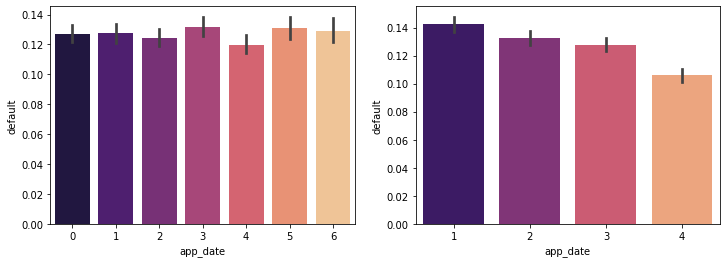

In [13]:
# Визуализация распределения дефолтов по дням недели и месяцам

fig = plt.figure()
ax_w = fig.add_subplot(1, 2, 1)
ax_m = fig.add_subplot(1, 2, 2)
fig.set_figwidth(12)
fig.set_figheight(4)

sns.barplot(data=scoring[scoring['part']==0],
            x=scoring.loc[scoring['part']==0,'app_date'].dt.weekday,
            y='default', palette="magma", ax=ax_w)


sns.barplot(data=scoring[scoring['part']==0],
            x=scoring.loc[scoring['part']==0,'app_date'].dt.month,
            y='default', palette="magma", ax=ax_m)

In [14]:
# Добавление нового признака ('месяц подачи заявки')

scoring['app_month'] = scoring['app_date'].dt.month

In [15]:
# Количество значений неясных целочисленных признаков 

for feat in ['region_rating','sna','first_time']:
    print(feat,':', len(scoring[feat].value_counts()))

region_rating : 7
sna : 4
first_time : 4


In [16]:
# Группировка признаков по типу

num_cols = ['age', 'decline_app_cnt', 'score_bki', 'bki_request_cnt', 'income']
bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']
cat_cols = ['app_month', 'education', 'region_rating', 'home_address', 'work_address', 'sna','first_time']

In [17]:
# Преобразование бинарных признаков

label_encoder = LabelEncoder()

for feat in bin_cols:
    scoring[feat] = label_encoder.fit_transform(scoring[feat])

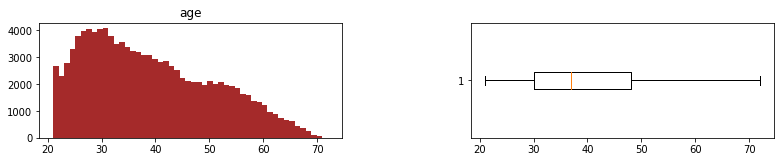

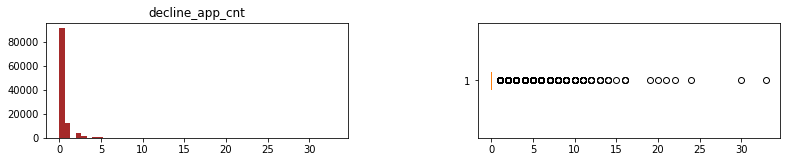

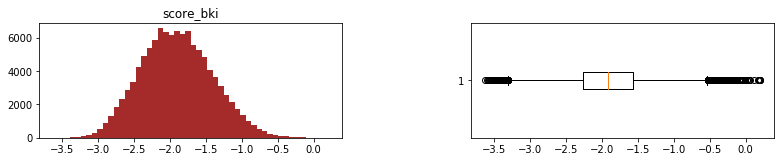

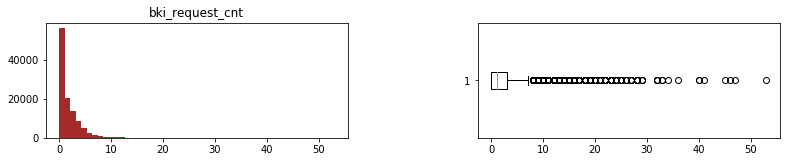

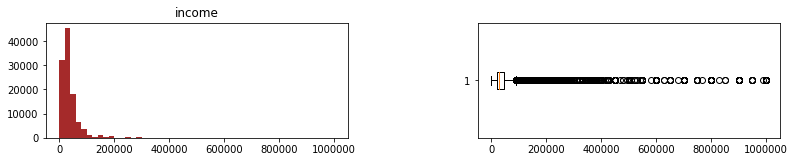

In [18]:
# Числовые признаки

for feat in num_cols:
    num_plots(scoring, feat, 'brown')

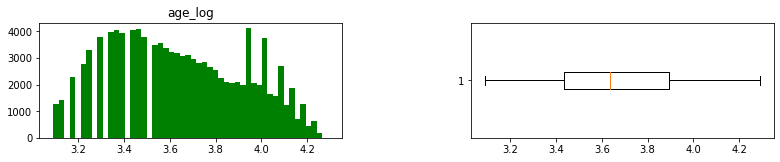

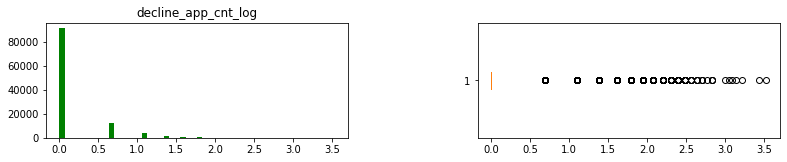

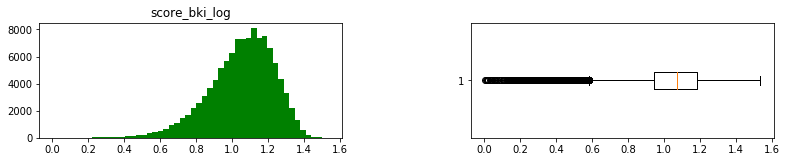

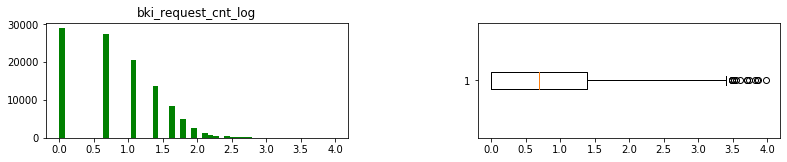

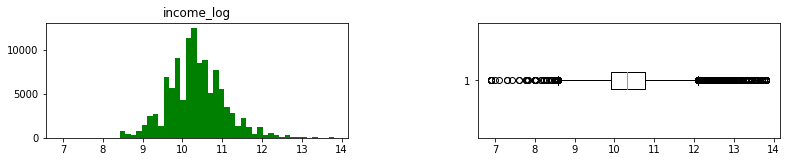

In [19]:
# Логарифмированные числовые признаки

for feat in num_cols:
    scoring[feat+'_log'] = np.log(abs(scoring[feat])+1) 
    num_plots(scoring, feat+'_log', 'green')

In [20]:
display(scoring['decline_app_cnt'].value_counts())

0     91471
1     12500
2      3622
3      1365
4       606
5       255
6       156
7        58
8        37
9        29
10       16
11       10
12        5
13        4
14        3
16        3
30        1
15        1
19        1
20        1
21        1
22        1
24        1
33        1
Name: decline_app_cnt, dtype: int64

In [21]:
# Преобразование признака 'количество отказов' в категориальный

scoring['decline_level'] = scoring['decline_app_cnt']

for i in range(0, len(scoring)):
    if scoring['decline_app_cnt'][i] >= 7:
        scoring['decline_level'][i] = 4
    elif scoring['decline_app_cnt'][i] in range (4,7):
        scoring['decline_level'][i] = 3
    elif scoring['decline_app_cnt'][i] in range (2,4):
        scoring['decline_level'][i] = 2

In [22]:
# Удаление выбросов в тренировочной части
# (из первоначального столбца'скоринговый балл'
# и логарифмированных 'количество запросов' и 'доход')

scoring_0 = scoring[scoring['part']==0]
scoring_1 = scoring[scoring['part']==1]

for feat in ['score_bki', 'bki_request_cnt_log', 'income_log']:
    scoring_0 = scoring_0[(scoring_0[feat] > out_lower(feat)) & (scoring_0[feat] < out_upper(feat))]

scoring_clean = scoring_0.append(scoring_1, sort=False).reset_index(drop=True)

In [23]:
num_fin = ['age_log', 'score_bki', 'bki_request_cnt_log', 'income_log']

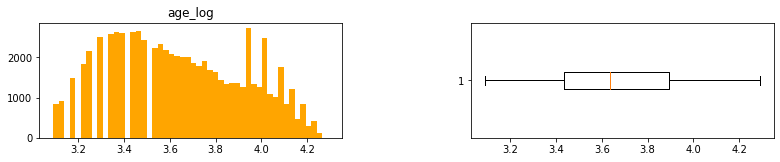

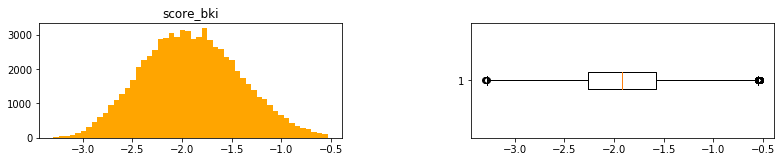

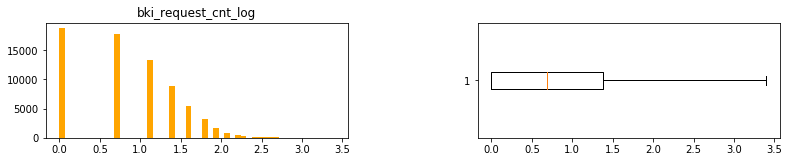

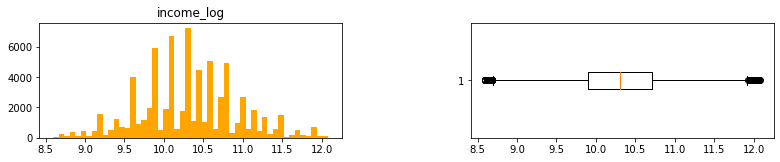

In [24]:
for feat in num_fin:
    num_plots(scoring_0, feat, 'orange')

In [25]:
# Объединение связанных бинарных признаков 'наличие автомобиля' и 'автомобиль-иномарка'
# в новый категориальный признак car_level
# (0 = нет машины, 1 = есть отечественная, 2 = есть иномарка)

scoring_clean['car_level'] = scoring_clean['car'] + scoring_clean['car_type']

In [26]:
bin_fin = ['sex', 'good_work', 'foreign_passport']

In [27]:
# Преобразование категориального признака 'уровень образования'

label_encoder.fit(scoring_clean['education'])
scoring_clean['education'] = label_encoder.transform(scoring_clean['education'])

In [28]:
cat_fin = ['app_month', 'education', 'region_rating', 'home_address', 'work_address', 'sna','first_time',
           'decline_level', 'car_level']

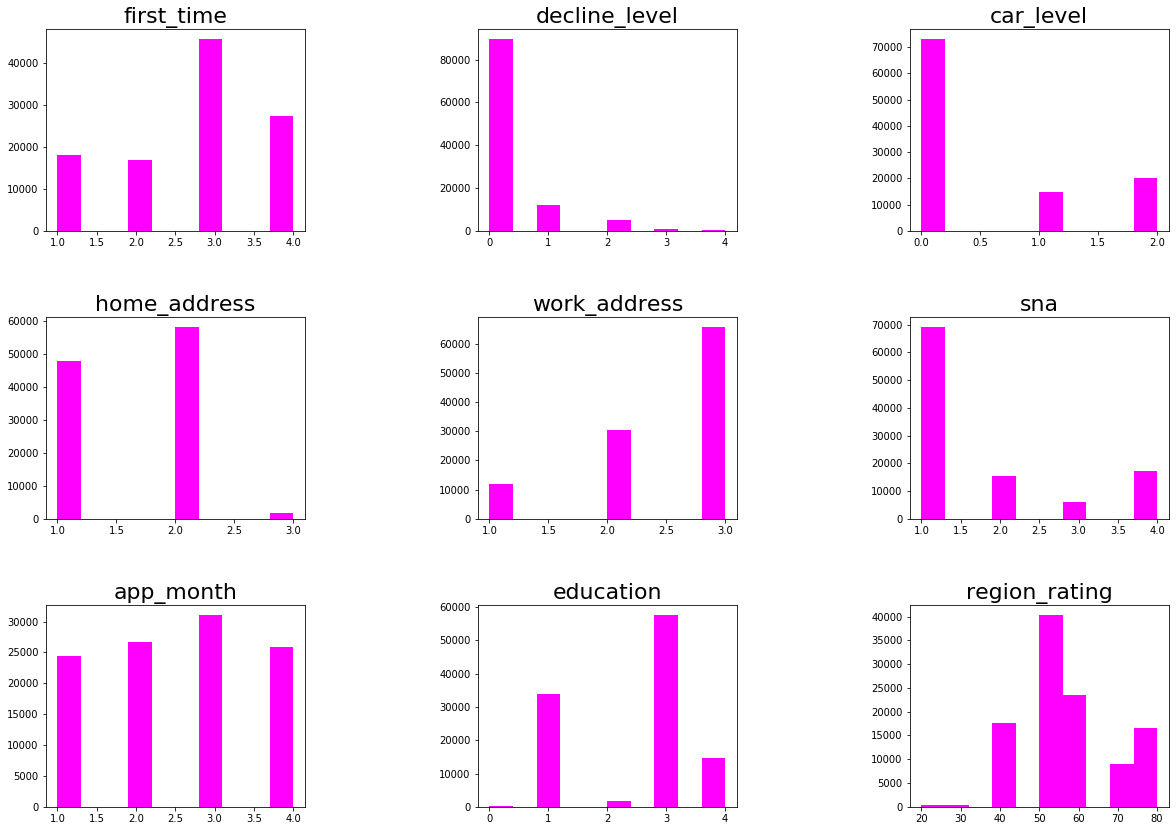

In [29]:
# Распределение категориальных признаков

fig = plt.figure()
k=0

for feat in cat_fin:
    cat_plots(scoring_clean, feat, 'magenta', k)
    k+=1

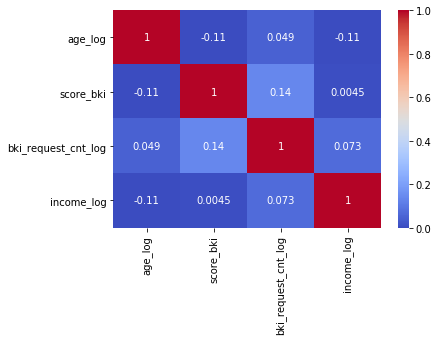

In [30]:
# Корреляция между числовыми признаками

sns.heatmap(scoring_clean[num_fin].corr(), vmin=0, vmax=1, cmap='coolwarm', annot=True)

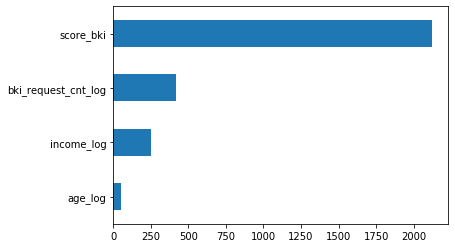

In [31]:
# Оценка значимости числовых признаков

imp_num = Series(f_classif(scoring_0[num_fin], scoring_0['default'])[0], index = num_fin)

imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

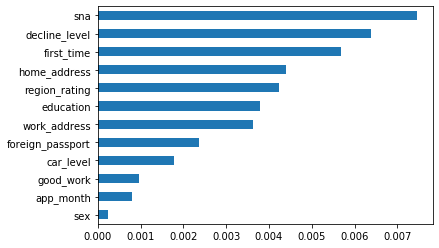

In [32]:
# Оценка значимости бинарных и категориальных признаков

imp_num = Series(mutual_info_classif(scoring_clean[scoring_clean['part']==0][bin_fin + cat_fin], 
                           scoring_clean[scoring_clean['part']==0]['default'],
                                     discrete_features=True), index = bin_fin + cat_fin)

imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

In [33]:
# Сильной корреляции нет.
# Столбцы 'пол и 'возраст' можно удалить как мало значимые.

num_fin.remove('age_log')
bin_fin.remove('sex')

In [34]:
# Сборка финального датасета

goal = ['default', 'part']
scoring_fin = scoring_clean[num_fin + bin_fin + cat_fin + goal]

In [35]:
display(scoring_fin.shape, scoring_fin.head(5))

(108051, 16)

,score_bki,bki_request_cnt_log,income_log,good_work,foreign_passport,app_month,education,region_rating,home_address,work_address,sna,first_time,decline_level,car_level,default,part
0,-2.008753,0.693147,9.798183,0,0,2,3,50,1,2,4,1,0,2,0.0,0
1,-1.532276,1.386294,9.852247,0,0,3,3,50,2,3,4,1,0,0,0.0,0
2,-1.408142,0.693147,10.308986,0,1,2,3,80,1,2,1,4,2,1,0.0,0
3,-2.057471,1.098612,9.210440,0,0,1,3,50,2,3,1,3,0,0,0.0,0
4,-1.244723,0.693147,10.308986,1,1,4,1,60,2,3,1,4,0,0,0.0,0


In [36]:
# Подготовка к обучению модели:

# cтандартизация числовых признаков
# в тренировочной и тестовой частях по отдельности

X_0_num = StandardScaler().fit_transform( scoring_fin[scoring_fin['part']==0] [num_fin].values)
X_1_num = StandardScaler().fit_transform( scoring_fin[scoring_fin['part']==1] [num_fin].values)


# добавление dummy-переменных

X_0_cat = OneHotEncoder(sparse = False).fit_transform( scoring_fin[scoring_fin['part']==0] [cat_fin].values)
X_1_cat = OneHotEncoder(sparse = False).fit_transform( scoring_fin[scoring_fin['part']==1] [cat_fin].values)

In [37]:
# объединение

X_0 = np.hstack([X_0_num, X_0_cat, scoring_0[bin_fin].values])
X_1 = np.hstack([X_1_num, X_1_cat, scoring_1[bin_fin].values])

y_0 = scoring_0['default'].values

In [38]:
# Обучение модели

X_0_train, X_0_valid, y_0_train, y_0_valid = train_test_split(X_0, y_0, test_size=0.20,
                                                              random_state=RANDOM_SEED)

model = LogisticRegression()
model.fit(X_0_train, y_0_train)

y_0_pred = model.predict(X_0_valid)

probs_0 = model.predict_proba(X_0_valid)
probs_0 = probs_0[:,1]

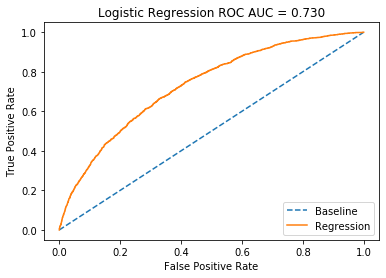

In [39]:
roc_auc_curve(y_0_valid, probs_0)

In [40]:
display(metrics(y_0_valid, y_0_pred, probs_0))

,scores
accuracy,0.874695
precision,0.453488
recall,0.021800
f1_score,0.041600
ROC_AUC,0.730034


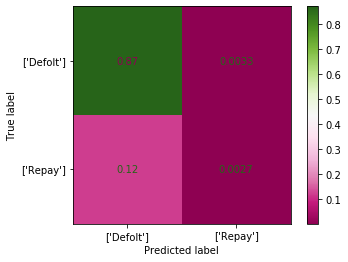

In [41]:
plot_confusion_matrix(model, X_0_valid, y_0_valid, normalize='all', 
                      display_labels=[['Defolt'],['Repay']], cmap='PiYG')

In [42]:
# Регуляризация

penalty = ['l1', 'l2']
C = np.logspace(0, 4, 10)
hyperparameters = dict(C=C, penalty=penalty)
mr = GridSearchCV(model, hyperparameters, cv=5, verbose=0)

model = mr.fit(X_0_train, y_0_train)

y_0_pred_reg = model.predict(X_0_valid)

probs_0_reg = model.predict_proba(X_0_valid)
probs_0_reg = probs_0_reg[:,1]

In [43]:
# Проверка сбалансированности выборки по классам

display(round(scoring_fin['default'].value_counts(1).min(),2))
display(round(scoring_fin['default'].value_counts(1).max(),2))

0.13

0.87

In [44]:
# Уменьшение тренировочной выборки (undersampling)

n = scoring_fin['default'].value_counts().min()
if len(scoring_fin [scoring_fin['default']==scoring_fin['default'][0]] ) == n:
    minor = scoring_fin['default'][0]
else:
    minor = 1-scoring_fin['default'][0]

scoring_bal = pd.concat([scoring_fin [scoring_fin['default']==minor],
                         scoring_fin [scoring_fin['default']==abs(minor-1)][:n]])

In [45]:
display(scoring_bal.shape)
display(scoring_bal['default'].value_counts())

(18176, 16)

0.0    9088
1.0    9088
Name: default, dtype: int64

In [46]:
# Обучение модели на сбалансированных данных

X_0b_num = StandardScaler().fit_transform(scoring_bal[num_fin].values)
X_0b_cat = OneHotEncoder(sparse = False).fit_transform(scoring_bal[cat_fin].values)
X_0b = np.hstack([X_0b_num, X_0b_cat, scoring_bal[bin_fin].values])
y_0b = scoring_bal['default'].values

X_0b_train, X_0b_valid, y_0b_train, y_0b_valid = train_test_split(X_0b, y_0b, test_size=0.20,
                                                              random_state=RANDOM_SEED, shuffle=True)

model.fit(X_0b_train, y_0b_train)

y_0b_pred = model.predict(X_0b_valid)

probs_0b = model.predict_proba(X_0b_valid)
probs_0b = probs_0b[:,1]

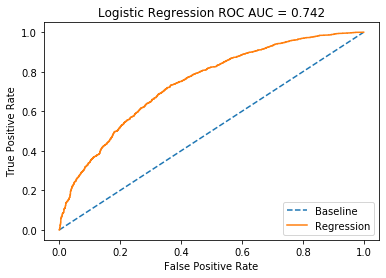

In [47]:
roc_auc_curve(y_0b_valid, probs_0b)

In [48]:
display(metrics(y_0b_valid, y_0b_pred, probs_0b))

,scores
accuracy,0.675743
precision,0.682601
recall,0.668845
f1_score,0.675653
ROC_AUC,0.742278


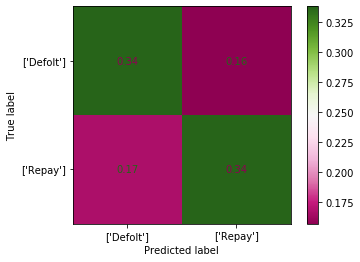

In [49]:
plot_confusion_matrix(model, X_0b_valid, y_0b_valid, normalize='all', 
                      display_labels=[['Defolt'],['Repay']], cmap='PiYG')

In [50]:
# Предсказание на тестовой части

probs_1 = model.predict_proba(X_1)
probs_1 = probs_1[:,1]

submit = pd.DataFrame(index = scoring_1['client_id'])
submit['default'] = probs_1

submit.to_csv('submission.csv')